# AI Machine Learning Practice 

# Informations

- Dataset: Music dataset

- Objectives: Classification

- Time Limits: 1 min

- Score: Classification Accuracy (Test Data)

- Please read all markdowns carefully 

- About Dataset: Music Style Data
    - 348 float type music features (frequency, tone, tempo, timbre...)
    - Label: Music Style
        - 1: Melancholy
        - 2: Romantic
        - 3: Rhythmical
    

## [Step 0] Importing Packages

You must specify all the packages you use in this practice in the cell below.



In [606]:
from __future__ import print_function
import os
data_path = ['data']

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

## [Step 1] Read Data

Train dataset is in the 'data' directory


In [607]:
import pandas as pd

# Import the data using the file path
filepath = os.sep.join(data_path + ['music_train_data.csv'])
data = pd.read_csv(filepath)

In [608]:
data.head(1)

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f340,f341,f342,f343,f344,f345,f346,f347,f348,answer
0,-0.166614,0.284691,-0.011022,-1.028812,0.101653,0.498247,-0.314566,1.208697,-1.503008,-1.457764,...,2.136721,-1.193955,0.040614,1.127366,0.741521,-0.70773,0.077748,0.832992,-1.291423,2


In [609]:
print(data.shape)
print(data.dtypes)

(650, 349)
f1        float64
f2        float64
f3        float64
f4        float64
f5        float64
           ...   
f345      float64
f346      float64
f347      float64
f348      float64
answer      int64
Length: 349, dtype: object


## [Step 2] Data Preprocessing

* Preprocessing Code below 
* You must explain your method in this markdown
* (Important) You must define transfrom function for test data

### My method
1. (processing skewed data)
    - skewed data를 찾고, log1p로 변환하여 skewness를 줄인다. 물론 log1n으로 변환하기 위해서는 음수를 피해야하므로 변환하기 전에 min값을 빼주면서 음수인 모든 값들을 0 이상으로 처리해주었다.
    (=> 하지만, 오히려 정확도가 감소하는 issue 발생으로 진행되지 않았음)
2. stratified shuffle spliting
    - Analysis에서 분석했듯이, 현재 class에 저장된 y-value들이 일정하게 분포되지 않고 편향되어 있으므로, train-test data를 나누는데 있어서 stratified shuffle spliting을 수행하여 같은 비율로 학습할 수 있게끔 설정했다.
3. scailing
    - Analysis에서 분석했듯이, Standard와 MinMax 두 가지의 scaler를 비교하여 무엇이 더 나은 성능을 보이는지를 확인한 후, scaling을 결정했다.

In [610]:
# find skewed feature

feature_cols = [x for x in data.columns if x not in 'answer']

skew_limit = 0.75
skew_vals = data[feature_cols].skew()

skew_cols = (skew_vals
             .sort_values(ascending=False)
             .to_frame()
             .rename(columns={0:'Skew'})
             .query('abs(Skew) > {0}'.format(skew_limit)))

skew_cols

,Skew
f65,25.353958
f66,25.154355
f13,9.475031
f116,5.060596
f14,5.037542
...,...
f70,-2.332200
f140,-2.593141
f179,-3.371065
f16,-6.985449


In [611]:
# make all values 0 or positive
# if min = -1, -1 - (-1) => 0

# data[feature_cols] = data[feature_cols] - data[feature_cols].min()

In [612]:
# converse to log1p

# for col in skew_cols.index.tolist():
#     if col == "answer":
#         continue
#     data[col] = np.log1p(data[col])

In [613]:
# split with StratifiedShuffleSplit

from sklearn.model_selection import StratifiedShuffleSplit

feature_cols = [x for x in data.columns if x not in 'answer']

strat_shuff_split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
train_idx, test_idx = next(strat_shuff_split.split(data[feature_cols], data['answer']))

X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'answer']
X_train_orig, y_train_orig = X_train.copy(), y_train.copy()

X_test = data.loc[test_idx, feature_cols]
y_test = data.loc[test_idx, 'answer']
X_test_orig, y_test_orig = X_test.copy(), y_test.copy()

In [614]:
# scaling with StandardScaler

import warnings
warnings.filterwarnings('ignore', module='sklearn')

std = StandardScaler()

X_train = pd.DataFrame(std.fit_transform(X_train_orig), columns=feature_cols)
X_test = pd.DataFrame(std.transform(X_test_orig), columns=feature_cols)

In [615]:
X_train.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f339,f340,f341,f342,f343,f344,f345,f346,f347,f348
0,-2.017288,1.803418,0.652271,-1.215750,-1.775327,-0.230436,-1.325403,-0.675451,-0.540297,0.659334,...,-1.565358,0.546102,0.339007,0.648162,-0.235878,0.597960,-3.203186,0.259669,-0.262743,0.051454
1,-0.211128,0.351116,-1.058943,-0.561983,-1.313109,-0.270270,0.808621,-0.957611,-0.467766,0.449276,...,0.121445,-0.657087,-1.043721,-0.179638,-1.023550,-0.258817,0.731170,-0.753804,-1.627850,0.032431
2,1.811220,-2.584682,-0.145336,0.087865,1.488953,0.904142,-0.219582,-0.478636,-1.056673,-2.094580,...,1.506551,-0.776128,-0.038626,-1.025651,-0.377229,-0.424313,-0.109686,1.761111,0.169628,-0.534843
3,0.652746,-0.616491,-0.804291,1.755921,0.492912,0.949013,-0.145281,0.578027,-0.860806,-0.889178,...,0.612643,-0.802544,-1.535288,0.150205,1.076019,1.047733,-0.550495,2.307089,0.217930,0.783118
4,0.684254,-0.746516,-1.631947,-0.375485,0.056339,0.133105,1.688899,-0.867656,-0.513091,1.416565,...,-1.261679,-0.482242,-0.920438,-0.538669,-1.288714,-0.326540,-0.332539,0.259669,-2.164343,1.034104


In [616]:
# transform function
# Do not change the function name
def transform_test(X_test_data):
    # X_test_data = X_test_data - X_test_data.min()
    # print(X_test_data.describe())

    # for col in skew_cols.index.tolist():
    #     X_test_data[col] = np.log1p(X_test_data[col])
    
    X_test_data = std.transform(X_test_data)
    return X_test_data

## Model Training

* Training Code Below
* You must explain your method in this markdown
* (Important) Your model variable should be named 'model' !!! 

### My Method
- Analysis에서 분석했듯, 가장 좋은 성능을 보이는 hyper parameter를 찾아 이를 가지는 Linear SVM model로 학습을 진행했다.
- 이는 Analysis에서 찍어본 data PCA plotting을 통해 눈으로 관찰한 결과, 3가지의 class로 나뉘는 data들 중 class 2에 해당하는 data set이 나머지 class data들과 아주 linear하게 분류가 가능하다는 사실을 알아내었고, 이를 가장 잘 분류할 수 있는 model을 가장 먼저 Linear SVM model로 예측하였으며 비교 실험을 진행하였다. 
- Gausian SVM model 그리고 KNN model과 Scaler를 각각 Standard와 MinMax로 두고서 Error metric으로 비교한 결과, Standard Scaler를 적용한 Linear SVM model의 정확도가 0.923076로 가장 높았다.
- DT model 및 Naive Bayes model의 경우, 앞서 진행했던 14주차 과제에서 비슷한 개수의 feature를 가진 data set을 가지고 진행했었는데 성능이 나쁘게 나왔으므로 비교에 있어서 사용하지 않고 진행하였다. (성능이 낮은 이유로는, DT의 경우에는 성능보다는 insight를 얻기 위한 목적의 model이며, NB의 경우에는 주어진 data set의 차원이 높아 모든 차원에 0~1사이의 값이 아주 많이 곱연산될 경우 최종 확률값이 낮아지기 때문이다.)

In [617]:
# Linear SVM with StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

model = LinearSVC(C=0.01, loss='squared_hinge', max_iter=1000)

model = model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           1       0.94      0.94      0.94        34
           2       0.96      0.96      0.96        24
           3       0.71      0.71      0.71         7

    accuracy                           0.92        65
   macro avg       0.87      0.87      0.87        65
weighted avg       0.92      0.92      0.92        65



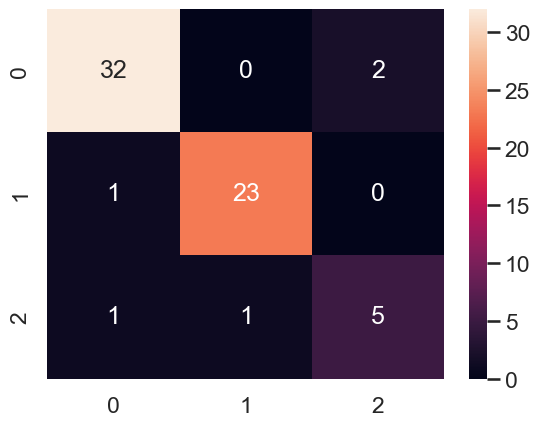

In [618]:
import seaborn as sns

sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d')

## Check Accuracy 

* Check your Train data accuracy

In [619]:
# Function to calculate the % of values that were correctly predicted

def accuracy(real, predict):
    return sum(real == predict) / float(real.shape[0])

In [620]:
print(accuracy(y_test, y_pred))

0.9230769230769231


## Analysis 

* Analyze your model's result
* You may use additional metrics (F1 Score, Confusion matrix) or visualize your results using plots
* Hint : PCA plot will help you understand the dataset (Which class is the most challenging class to classify?)
* Hint : You may also compare different models to choose the best model among classifiers what we learned in this semester

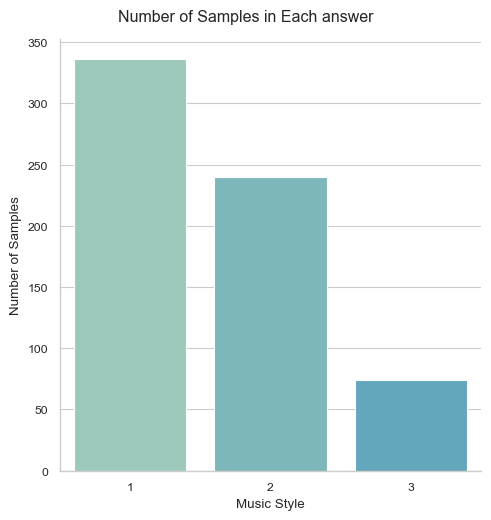

In [621]:
# Your code here

# check for unbalance y-value dataset

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
sns.set_context('paper')
sns.set_palette('GnBu_d')
a = sns.catplot(x='answer', data=data, kind='count')
a.fig.suptitle('Number of Samples in Each answer', y=1.03)
a.set(ylabel='Number of Samples', xlabel='Music Style')
plt.show()

In [622]:
# PCA ploting

from sklearn.decomposition import PCA 
import plotly.express as px

pca_data = PCA(n_components=3).fit_transform(data)
plot_df = pd.DataFrame.from_records(data=pca_data,columns=['pc1','pc2','pc3'])
plot_df['target'] = data['answer']
fig = px.scatter_3d(plot_df, x='pc1', y='pc2', z='pc3', color='target', width=600, height=600)
fig.show()

According to PCA plotting, class 1 and class 3 => hard to classify!

Linear classification will be useful..

In [623]:
# define error metric function

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix

def measure_error(y_true, y_pred, label):
    return pd.Series({'accuracy':accuracy_score(y_true, y_pred),
                      'recall': recall_score(y_true, y_pred, average='micro'),
                      'f1': f1_score(y_true, y_pred, average='micro')},
                      name=label)

In [624]:
# "Best" Model = Linear SVM with StandardScaler

from sklearn.model_selection import GridSearchCV

SVC_linear = LinearSVC()
grid = GridSearchCV(SVC_linear, 
                  param_grid={
                    'penalty':['l1', 'l2'],
                    'loss':['hinge', 'squared_hinge'], 
                    'C':[0.01, 0.1, 1, 10, 100],
                    'max_iter':[1000, 10000]
                    }, 
                  scoring='accuracy')

grid.fit(X_train, y_train)

grid.best_params_

{'C': 0.01, 'loss': 'squared_hinge', 'max_iter': 1000, 'penalty': 'l2'}

In [625]:
LSVC = LinearSVC(C=0.01, loss='squared_hinge', max_iter=1000)

LSVC = LSVC.fit(X_train, y_train)

y_pred = LSVC.predict(X_test)

print(confusion_matrix(y_test, y_pred))

error_metric = measure_error(y_test, y_pred, 'best case')
error_metric

[[32  0  2]
 [ 1 23  0]
 [ 1  1  5]]


accuracy    0.923077
recall      0.923077
f1          0.923077
Name: best case, dtype: float64

In [626]:
# Gaussian kernel SVM model with StandardScaler

from sklearn.svm import SVC

# SVC_Gaussian = SVC(kernel='rbf')
# grid = GridSearchCV(SVC_Gaussian, 
#                   param_grid={
#                       'gamma':[0.0001, 0.001, 0.01, 0.1, 1, 10], 
#                       'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}, 
#                   scoring='accuracy')

# grid.fit(X_train, y_train)

# grid.best_params_

In [627]:
GS = SVC(kernel='rbf', gamma=0.0001, C=10)

GS = GS.fit(X_train, y_train)

y_pred = GS.predict(X_test)

print(confusion_matrix(y_test, y_pred))

error_metric = measure_error(y_test, y_pred, 'Gaussian SVM')
error_metric

[[33  0  1]
 [ 1 23  0]
 [ 5  1  1]]


accuracy    0.876923
recall      0.876923
f1          0.876923
Name: Gaussian SVM, dtype: float64

In [628]:
# KNN model with StandardScaler

# knn = KNeighborsClassifier()
# grid = GridSearchCV(knn, 
#                   param_grid={
#                       'n_neighbors':list(range(1, 31)), 
#                       'p':list(range(1,3)),
#                       'weights':['uniform', 'distance']
#                       },
#                   scoring='accuracy',
#                   )

# grid.fit(X_train, y_train)

# grid.best_params_

In [629]:
KNN = KNeighborsClassifier(n_neighbors=17, p=1, weights='distance')

KNN = KNN.fit(X_train, y_train)

y_pred = KNN.predict(X_test)

print(confusion_matrix(y_test, y_pred))

error_metric = measure_error(y_test, y_pred, 'KNN')
error_metric

[[32  2  0]
 [ 1 23  0]
 [ 3  1  3]]


accuracy    0.892308
recall      0.892308
f1          0.892308
Name: KNN, dtype: float64

Now, compare MinmaxScaler with StandardScaler

In [630]:
msc = MinMaxScaler()

X_train = pd.DataFrame(msc.fit_transform(X_train_orig), columns=feature_cols)
X_test = pd.DataFrame(msc.transform(X_test_orig), columns=feature_cols)

In [631]:
# Linear SVM with MinMaxScaler

# SVC_linear = LinearSVC()
# grid = GridSearchCV(SVC_linear, 
#                   param_grid={
#                     'penalty':['l1', 'l2'],
#                     'loss':['hinge', 'squared_hinge'], 
#                     'C':[0.01, 0.1, 1, 10, 100],
#                     'max_iter':[1000, 10000]
#                     }, 
#                   scoring='accuracy')

# grid.fit(X_train, y_train)

# grid.best_params_

In [632]:
LSVC = LinearSVC(C=0.1, loss='hinge', max_iter=1000)

LSVC = LSVC.fit(X_train, y_train)

y_pred = LSVC.predict(X_test)

print(confusion_matrix(y_test, y_pred))

error_metric = measure_error(y_test, y_pred, 'MinMax LSVC')
error_metric

[[33  0  1]
 [ 1 23  0]
 [ 4  1  2]]


accuracy    0.892308
recall      0.892308
f1          0.892308
Name: MinMax LSVC, dtype: float64

In [633]:
# Gaussian kernel SVM model with MinMaxScaler

from sklearn.svm import SVC

# SVC_Gaussian = SVC(kernel='rbf')
# grid = GridSearchCV(SVC_Gaussian, 
#                   param_grid={
#                       'gamma':[0.0001, 0.001, 0.01, 0.1, 1, 10], 
#                       'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}, 
#                   scoring='accuracy')

# grid.fit(X_train, y_train)

# grid.best_params_

In [634]:
GS = SVC(kernel='rbf', gamma=0.01, C=10)

GS = GS.fit(X_train, y_train)

y_pred = GS.predict(X_test)

print(confusion_matrix(y_test, y_pred))

error_metric = measure_error(y_test, y_pred, 'MinMax Gaussian SVM')
error_metric

[[31  0  3]
 [ 1 23  0]
 [ 2  1  4]]


accuracy    0.892308
recall      0.892308
f1          0.892308
Name: MinMax Gaussian SVM, dtype: float64

In [635]:
# KNN model with MinMaxScaler

# knn = KNeighborsClassifier()
# grid = GridSearchCV(knn, 
#                   param_grid={
#                       'n_neighbors':list(range(1, 31)), 
#                       'p':list(range(1,3)),
#                       'weights':['uniform', 'distance']
#                       },
#                   scoring='accuracy',
#                   )

# grid.fit(X_train, y_train)

# grid.best_params_

In [636]:
KNN = KNeighborsClassifier(n_neighbors=19, p=1, weights='uniform')

KNN = KNN.fit(X_train, y_train)

y_pred = KNN.predict(X_test)

print(confusion_matrix(y_test, y_pred))

error_metric = measure_error(y_test, y_pred, 'MinMax KNN')
error_metric

[[34  0  0]
 [ 1 23  0]
 [ 2  1  4]]


accuracy    0.938462
recall      0.938462
f1          0.938462
Name: MinMax KNN, dtype: float64

So, best model is Linear SVM with StandardScaler

# Test data

* TA will check your model's test data accuracy
* (Important) Do not change the code below

In [637]:
filepath = os.sep.join( ['data', 'music_test_data.csv'])
t_data = pd.read_csv(filepath)
features = t_data.columns
X_t_data = t_data[features]
X_t_data = transform_test(X_t_data)

y_pred = model.predict(X_t_data)
np.savetxt('out.txt', y_pred, fmt='%d', delimiter='\n')

In [638]:
n1 = 0
n2 = 0
n3 = 0

for x in y_pred:
    if x == 1:
        n1 = n1 + 1
    elif x == 2:
        n2 = n2 + 1
    else:
        n3 = n3 + 1

print(n1, n2, n3)

89 55 18
